In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from utils import get_contribution
from itertools import product


warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 


In [3]:
figure_config = yaml.safe_load(open("figures_config.yml", "r"))
dataset_map = figure_config["datasets"]
method_order = figure_config["method_order"]
method_colormap = figure_config["method_colormap"]
methods_map = figure_config["methods"]
scenarios = {}

for config_path in pathlib.Path("../configs").iterdir():
    if config_path.stem == "config":
        continue
    config = yaml.safe_load(open(config_path, "r"))
    for scenario, values in config["scenarios"].items():
        values["root"] = config["root"]
        if "gbm_subsample" in config["root"]:
            continue
        scenarios[scenario] = values


In [14]:
OUT_STUDY = {
    "bischoff_lung": ("Kim_3",),
    "laughney_lung": ("Kim_3",),
    "couturier_brain": ("Neftel_4", "Neftel_6"),
    "wang_brain": ("Neftel_4", "Neftel_6"),
    "yuan_brain": ("Neftel_4", "Neftel_6"),
}

OUT_STUDY_ORDER = [
    "Yuan (Neftel 4)", "Yuan (Neftel 6)",
    "Couturier (Neftel 4)", "Couturier (Neftel 6)",
    "Wang (Neftel 4)", "Wang (Neftel 6)",
    "Bischoff (Kim 3)", "Laughney (Kim 3)"
]

In [15]:
path_scores = "../{root}/scores/type/scrna/{study}.csv"

scores = []
for study, sigs in OUT_STUDY.items():
    for sig in sigs:
        file_path = path_scores.format(root=scenarios[study]["root"], study=study)
        df = pd.read_csv(file_path)
        df["Dataset"] = dataset_map[study] + " (" +sig.title().replace("_", " ") + ")"
        df = df[df["Signature"]==sig].copy()
        if df.shape[0] == 0:
            raise ValueError("Signature not found.")
        scores.append(df)
df = pd.concat(scores, axis=0)
df["#Cluster"] = df["Cluster"] - df["Signature"].str.rsplit("_", n=1).str[1].astype(int)
df["Dataset"] = df["Dataset"].astype(str)
df = df.drop(["Signature", "Cluster", "Split"], axis=1)
df = df.set_index(["Dataset", "#Cluster"])
df = df.unstack()
df = df.rename(columns=methods_map)
df = df.sort_index(key=lambda x: x.map(method_order.index), axis=1, level=0)
df = df.sort_index(key=lambda x: x.map(OUT_STUDY_ORDER.index))
method_order = list(filter(lambda x: x in df.columns, method_order))






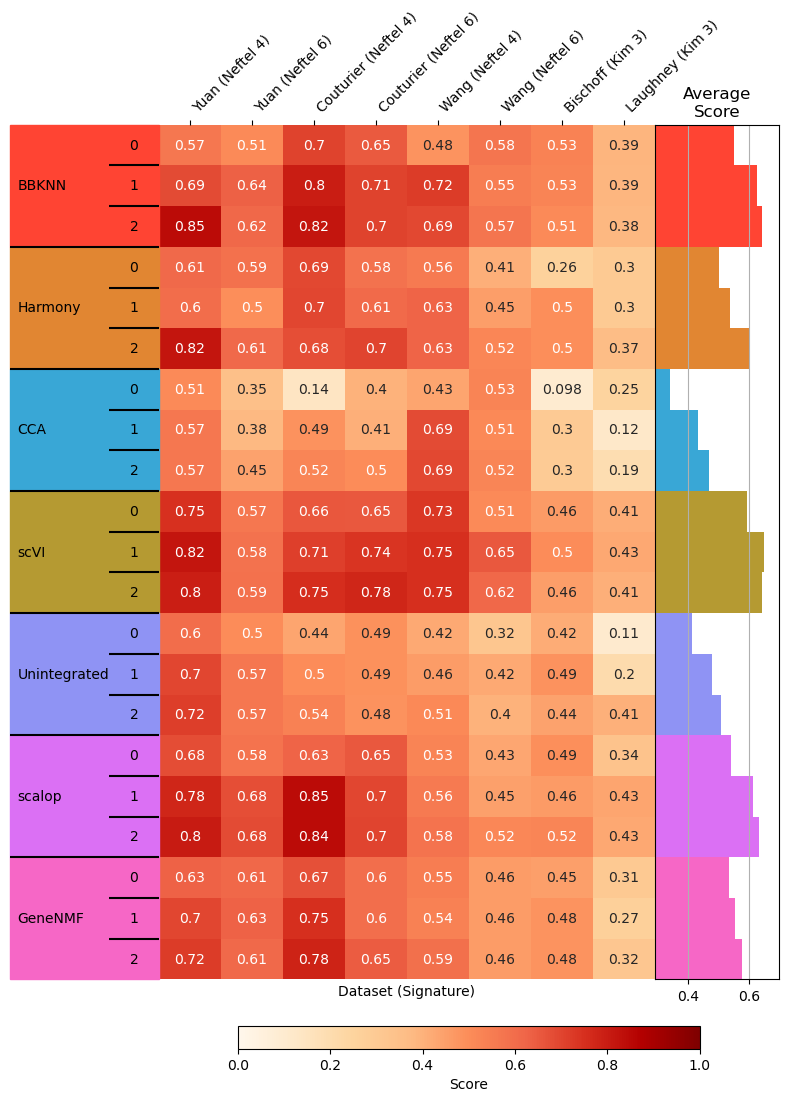

In [16]:
fig = plot_heatmap_with_bar_plot(df, xlabel="Dataset (Signature)")
fig.savefig("fig_4/heatmap.svg", bbox_inches="tight")

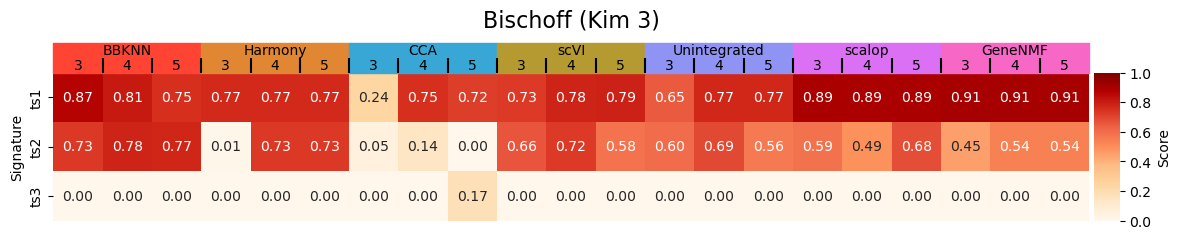

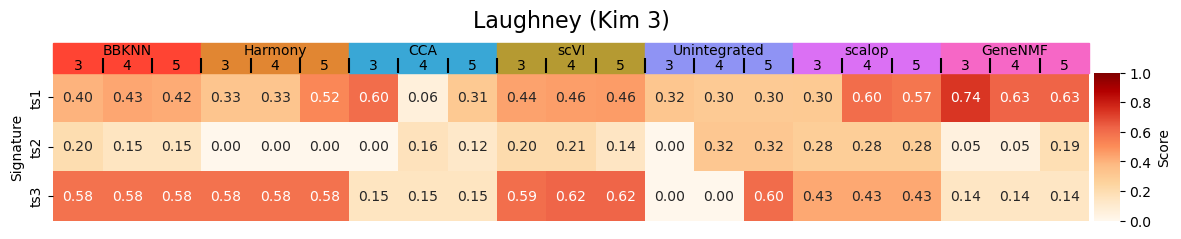

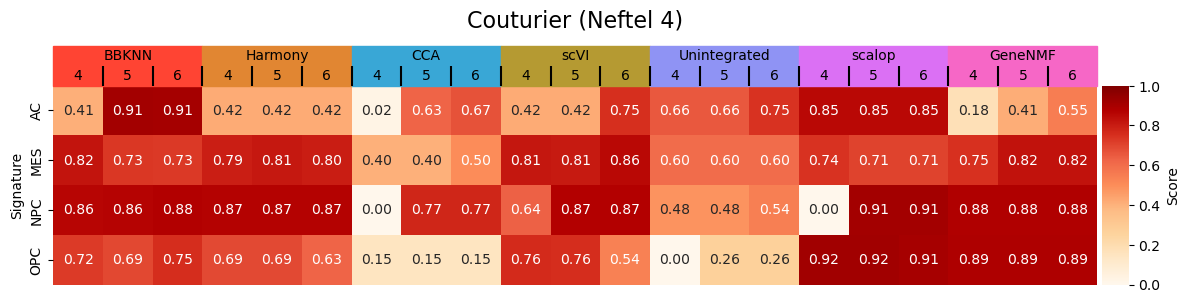

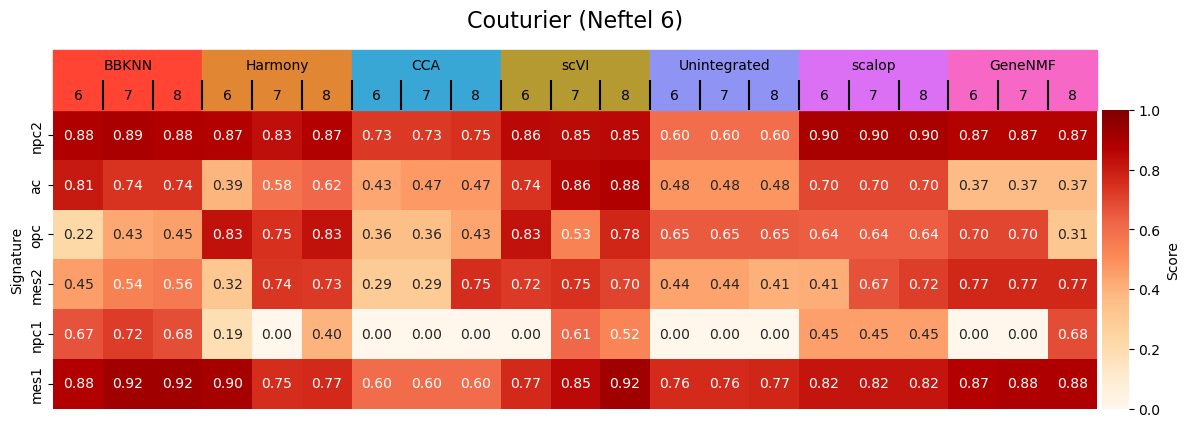

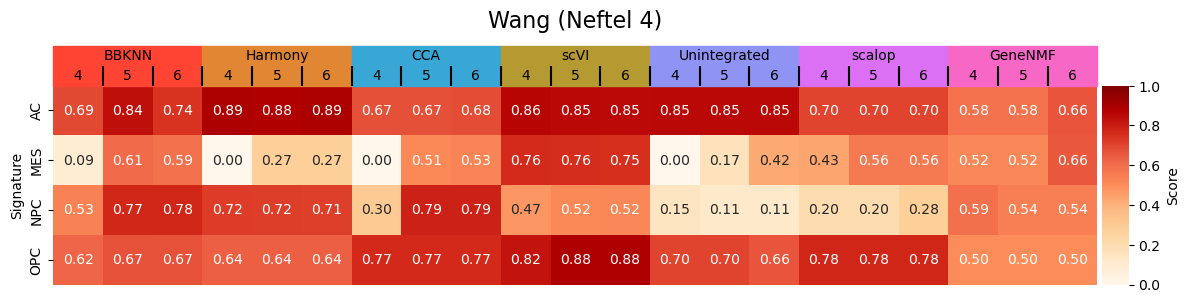

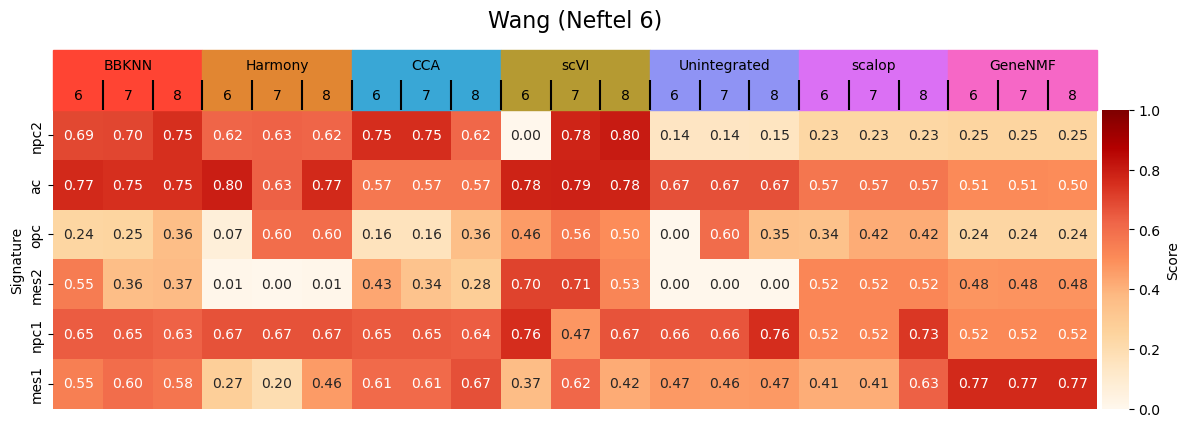

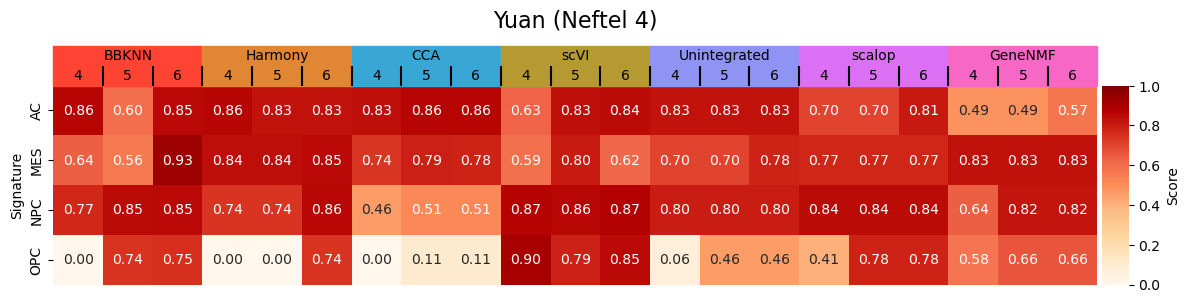

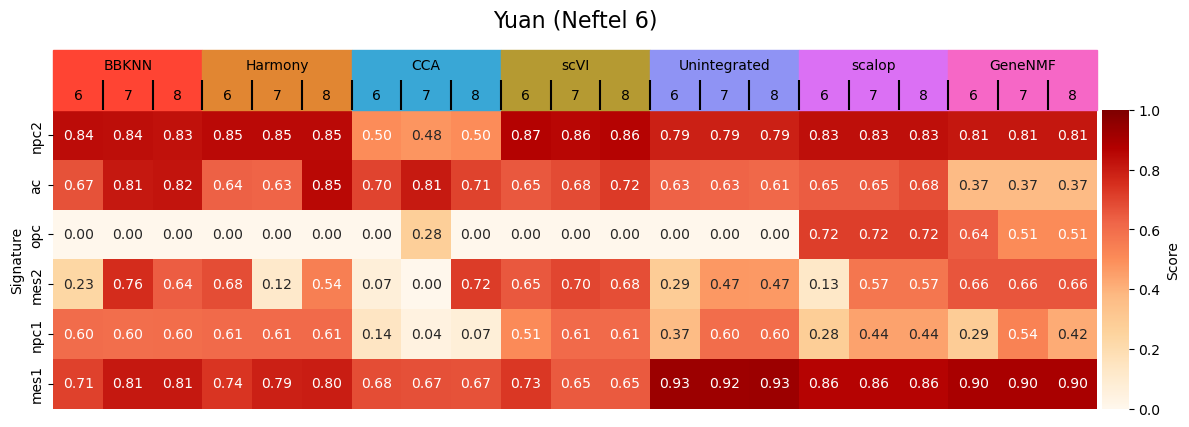

In [20]:
scens = {("luad", "bischoff_lung"): ("kim_3",),
("luad", "laughney_lung"): ("kim_3",),
("gbm","couturier_brain"): ("neftel_4", "neftel_6"),
("gbm","wang_brain"): ("neftel_4", "neftel_6"),
("gbm","yuan_brain"): ("neftel_4", "neftel_6")}
for (cancer_type, scenario), signatures in scens.items():
    for signature in signatures:
        results = get_contribution(cancer_type, scenario, signature)
        results.index.name = "Method"
        results = results.reset_index()
        results["Method"] = results["Method"].map(methods_map.get)
        results["Method"] = pd.Categorical(results['Method'], categories=method_order, ordered=True)
        results = results.sort_values(by=['Method', '#Cluster'], ascending=[True, True])
        results = results.reset_index().set_index(["Method", "#Cluster"]).transpose()
        df = results.drop("index")
        fig, ax = plt.subplots(figsize=(12, 6))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)
        sns.heatmap(df, vmax=1., vmin=0., cmap="OrRd", center=0.5, ax=ax, annot=True, square=True, cbar_kws={"label": "Score"}, fmt='.2f', cbar_ax=cax)
        n_ticks = df.shape[1]
        for i, (method, cluster) in enumerate(df.columns):
            if (i%3) == 0:
                ax.add_patch(Rectangle(((i)/n_ticks, 1.0), 3/n_ticks, 0.2, color=method_colormap[method], transform=ax.transAxes, clip_on=False))
                ax.text((i+3)/n_ticks - 3/(2*n_ticks), 1.15, method,  ha="center", va="center", transform=ax.transAxes)
                current_method = method
            else:
                if method != current_method:
                    raise ValueError("Dataframe was not sorted!")

            ax.text(((i + 1) / n_ticks) - 1 / (2 * n_ticks), 1.05, cluster, ha="center", va="center", transform=ax.transAxes)
        ax.vlines(x=[i/n_ticks for i in range(1, n_ticks)], ymin=1., ymax=1.1, colors="black", transform=ax.transAxes, clip_on=False)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.xaxis.set_tick_params(labeltop=True)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("Signature")
        dataset = dataset_map[scenario] + " (" +signature.title().replace("_", " ") + ")"
        ax.set_title(f"{dataset}", fontsize=16, y=1.25)
        fig.tight_layout()

        fig.savefig(f"fig_4/{scenario}_{signature}.svg", bbox_inches="tight")